# Импорты

In [2]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pymorphy2
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud, STOPWORDS
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Operator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных, беглый осмотр и чистка

In [3]:
# Загружаем датасет, смотрим структуру данных
df = pd.read_csv('train.csv', index_col=0)
df.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
# Смотрим краткую информацию о данных в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41159 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41158 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.7+ KB


In [5]:
# Смотрим варианты уникальных значений меток 
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive', nan], dtype=object)

In [6]:
# Смотрим количество данных с NaN
df[df.Sentiment.isna()]

,Text,Sentiment
33122,@PrivyCouncilCA #SocialDistancing isnÂt enoug...,NaN
NaN,Neutral,NaN
39204,@TanDhesi @foreignoffice @Afzal4Gorton @Expres...,NaN
Neutral,NaN,NaN


In [7]:
# Так как их совсем немного, нет нужды править, проще сбросить
df.dropna(inplace=True)

# Разбивка на обучающую и валидационную части

In [8]:
# Разбиваем набор на обучающую и валидационную части (0.75-0.25)
df_train, df_test, _, _ = train_test_split(df,
                                           df.Sentiment,
                                           shuffle=True,
                                           test_size=0.25,
                                           random_state=42)

In [9]:
# Сохраняем валидационную выборку отдельно
df_test.to_csv('val_data.csv', index=True)

In [76]:
df_train.to_csv('train_data.csv', index=True)

In [10]:
df_train.shape[0]

30866

In [11]:
# Это чтобы дальше не использовать длинных названий
df = df_train.copy()

# Часть 1 - запрет на использование ML для классификации

## Более подробный осмотр с разбивкой по целевым классам

In [12]:
# Смотрим разбивку данных по меткам
for label in df.Sentiment.unique():
    print(label, df[df.Sentiment == label].shape[0])

Neutral 5813
Negative 7428
Extremely Negative 4122
Extremely Positive 4941
Positive 8562


In [13]:
neutral = df[df.Sentiment == 'Neutral']
positive = df[df.Sentiment == 'Positive']
extremely_negative = df[df.Sentiment == 'Extremely Negative']
negative = df[df.Sentiment == 'Negative']
extremely_positive = df[df.Sentiment == 'Extremely Positive']


In [14]:
extremely_negative.head(5)

,Text,Sentiment
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative
16711,5. Lets pledge not to hoard essential supplies...,Extremely Negative
3746,hey google what the actual fuck this is the se...,Extremely Negative
6291,If we think it's bad now what with a lack of #...,Extremely Negative
23676,Compelling insights from the consumer survey r...,Extremely Negative


In [15]:
extremely_positive.head(5)

,Text,Sentiment
36665,?? I repeat my call for respect of #consumerpr...,Extremely Positive
38638,"The #British love to queue, so with all this #...",Extremely Positive
37135,"@NatureNews That's a scary part. However, give...",Extremely Positive
33061,Just a thought. But would it be possible to st...,Extremely Positive
36598,6 Stocks That Will Benefit From a Dovish Feder...,Extremely Positive


Так как я не являюсь носителем языка и владею им только на уровне B2, мне сложно понять критерий соотнесения вот этих вот примеров к крайним вариантам "экстремально_позитивный" и "экстремально_негативный". В парочке из них есть слова fuck bad и love, поэтому, похоже, разметка более-менее основной сути соответствует. ОК, будем пробовать искать какие-то статистические различия, типа длины строки, количества слов, ссылок или спецсимволов.

Сравнения буду проводить на классах экстремально_позитивный и экстремально_негативный, чтобы разница в каких-то статистических параметрах текста была видна более ярко.

## Попытка разделения №1 - по длине строки в разных классах

In [16]:
# Функция для препроцессинга строк
def transform_rows(row: str) -> list:
    '''Убираем из строки лишние разделители и разбиваем на слова'''
    try:
        row = row.replace('/', ' ')
        row = row.replace('-', ' ')
        row = row.replace(',', ' ')
        row = row.replace('.', ' ')
        row = row.replace('=', ' ')
        row = row.replace('+', ' ')
        row = row.lower()
        list_of_word = row.split()
    except Exception:
        list_of_word = []

    return list_of_word 

In [17]:
# Пробую сравнить количество слов в строках с максимально
# удаленными метками экстремально_позитивный и экстремально_негативный
# Применяем созданную функцию к текстовым строкам датафрейма,
# помещаем получившийся результат в новый столбец
extremely_negative['Text_to_list'] = extremely_negative.Text.apply(transform_rows)
extremely_positive['Text_to_list'] = extremely_positive.Text.apply(transform_rows)

C:\Users\Operator\AppData\Local\Temp\ipykernel_10704\3603441540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremely_negative['Text_to_list'] = extremely_negative.Text.apply(transform_rows)
C:\Users\Operator\AppData\Local\Temp\ipykernel_10704\3603441540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremely_positive['Text_to_list'] = extremely_positive.Text.apply(transform_rows)


In [18]:
extremely_negative.head(5)

,Text,Sentiment,Text_to_list
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative,"[#caremongering, #maskfear, #coronavirus, #cov..."
16711,5. Lets pledge not to hoard essential supplies...,Extremely Negative,"[5, lets, pledge, not, to, hoard, essential, s..."
3746,hey google what the actual fuck this is the se...,Extremely Negative,"[hey, google, what, the, actual, fuck, this, i..."
6291,If we think it's bad now what with a lack of #...,Extremely Negative,"[if, we, think, it's, bad, now, what, with, a,..."
23676,Compelling insights from the consumer survey r...,Extremely Negative,"[compelling, insights, from, the, consumer, su..."


In [19]:
# Пишем функцию для подсчета количества слов в строке
def count_words(list_of_words: list) -> int:
    
    return len(list_of_words)

In [20]:
# Добавляем столбец с количеством слов в строке
extremely_negative['Words_cnt'] = extremely_negative.Text_to_list.apply(count_words)
extremely_positive['Words_cnt'] = extremely_positive.Text_to_list.apply(count_words)

C:\Users\Operator\AppData\Local\Temp\ipykernel_10704\2126258093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremely_negative['Words_cnt'] = extremely_negative.Text_to_list.apply(count_words)
C:\Users\Operator\AppData\Local\Temp\ipykernel_10704\2126258093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremely_positive['Words_cnt'] = extremely_positive.Text_to_list.apply(count_words)


In [21]:
extremely_negative.head(5)

,Text,Sentiment,Text_to_list,Words_cnt
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative,"[#caremongering, #maskfear, #coronavirus, #cov...",25
16711,5. Lets pledge not to hoard essential supplies...,Extremely Negative,"[5, lets, pledge, not, to, hoard, essential, s...",49
3746,hey google what the actual fuck this is the se...,Extremely Negative,"[hey, google, what, the, actual, fuck, this, i...",35
6291,If we think it's bad now what with a lack of #...,Extremely Negative,"[if, we, think, it's, bad, now, what, with, a,...",35
23676,Compelling insights from the consumer survey r...,Extremely Negative,"[compelling, insights, from, the, consumer, su...",32


In [22]:
extremely_negative.Words_cnt.describe()

count    4122.000000
mean       36.237263
std        10.416746
min         6.000000
25%        29.000000
50%        38.000000
75%        44.000000
max        61.000000
Name: Words_cnt, dtype: float64

In [23]:
extremely_positive.Words_cnt.describe()

count    4941.000000
mean       36.965392
std         9.927522
min         6.000000
25%        31.000000
50%        38.000000
75%        45.000000
max        65.000000
Name: Words_cnt, dtype: float64

Ну, этот заход стоит признать неудачным. Статистика по количеству слов практически не различается. Разве что попробовать сделать отсечку на длине 61 и классифицировать всё, что больше, как позитивный класс.

## Попытка №2 - делаю "множества слов" для разных классов

In [37]:
# Добавляю необходимые функции
def preprocess(lst: list) -> list:
    '''Функция принимает на вход список сообщений, предобрабатывает его,
       и возвращет без лишних слов :)'''
    # Приводим к нижнему регистру
    bag = ' '.join(lst).lower()
    # Убираем цифры
    numbers = re.compile(r'\d+')
    bag = re.sub(numbers, '', bag)
    # Убираем пунктуацию
    punct = re.compile(r'[^\w\s]')
    bag = re.sub(punct, '', bag)
    # Удаляем ссылки
    url = re.compile(r'((?<=[^a-zA-Z0-9])(?:https?\:\/\/|[a-zA-Z0-9]{1,}\.{1}|\b)(?:\w{1,}\.{1}){1,5}(?:com|co|org|edu|gov|uk|net|ca|de|jp|fr|au|us|ru|ch|it|nl|se|no|es|mil|iq|io|ac|ly|sm){1}(?:\/[a-zA-Z0-9]{1,})*)')
    bag = re.sub(url, '', bag)
    # Убираем спецсимволы:
    symbols = re.compile(r'\n')
    bag = re.sub(symbols, '', bag)
    # Убираем лишние пробелы
    #extra_spaces = re.compile(r'\s{2,}')
    #bag = re.sub(extra_spaces, ' ', bag)
    # Лемматизация и очистка от стопслов
    morph = pymorphy2.MorphAnalyzer()
    stop = stopwords.words('english')
    bag = [morph.normal_forms(word)[0] for word in bag.split() if word not in stop]

    return bag


def make_clouds(df: pd.DataFrame) -> tuple:
    ''' Создаем списки слов из позитивных и негативных комментариев'''
    positive_list = []
    negative_list = []
    positive_texts = df.index[
        (df.loc[:, 'Sentiment'] == 'Extremely Positive') |
        (df.loc[:, 'Sentiment'] == 'Positive')].tolist()
    for idx in positive_texts:
        positive_list.append(df.loc[idx, 'Text'])
    negative_texts = df.index[
        (df.loc[:, 'Sentiment'] == 'Extremely Negative') |
        (df.loc[:, 'Sentiment'] == 'Negative')].tolist()
    for idx in negative_texts:
        negative_list.append(df.loc[idx, 'Text'])
    positive_bag = preprocess(positive_list)
    negative_bag = preprocess(negative_list)

    return positive_bag, negative_bag

In [38]:
positive_bag, negative_bag = make_clouds(df)

Наверняка самые упоминаемые в связи с контекстом комментариев слова (короновирус, КОВИД и некоторые друие) находятся в топе и там и там. Но тем не менее также есть определенные различия даже в топе наиболее упоминаемых слов, что можно использовать для разметки. Нужно выделить именно эти отличающиеся слова. Обращаю внимание, что это ещё не полноценные "мешки слов", которые учитывают количество вхождений слова в исследуемом датасете, поэтому это не может считаться применением методов ML и какой-то векторизацией слов, мы просто создали два списка слов без какой-либо их трансформации в числовой вид.

In [40]:
# Делаем множество, чтобы проще найти разность
negative_set = set(negative_bag)
positive_set = set(positive_bag)

In [41]:
# Вычитаем из множеств совпадающие элементы
negative_set_ = negative_set - positive_set
positive_set = positive_set - negative_set
negative_set = negative_set_

In [42]:
len(negative_set)

19709

In [43]:
len(positive_set)

25103

In [51]:
# Как ни странно, всякие такие слова есть в обоих мешках и были сброшены
print('love' in negative_bag)
print('fuck' in positive_bag)

True
True


Итак, у нас уже имеется два правила, по которому можно классифицировать комментарии без использования алгоритмов машинного обучения:
- по максимальной длине сообщения;
- по нахождению слов комментария в множестве "хороших" или "плохих" слов. Осталось придумать, как это использовать на практике.

## Тестируем гипотезы на тестовой выборке

In [61]:
# Загружаем датасет, смотрим структуру данных
df = pd.read_csv('val_data.csv', index_col=0)
df.head(5)

,Text,Sentiment
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative
23458,I would place a large amount of money this is ...,Neutral
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive


In [57]:
def labeling_str(row: str) -> int:
    '''
    Присваиваем сообщению числовую метку в зависимости
    от количества слов, находящихся в списке "хороших"
    и "плохих". Каждое "хорошее" слово +1, "плохое" -1.
    '''
    global positive_set
    global negative_set   
    row = row.split()
    row = preprocess(row)
    cnt = 0
    for word in row:
        if word in positive_set:
            cnt += 1
        elif word in negative_set:
            cnt -= 1
        else:
            pass

    label = ''
    if (cnt == 0) & (len(row) <= 61):
        label = 'Neutral'
    if (cnt == 0) & (len(row) > 61):
        label = 'Extremely Positive'
    elif cnt == 1:
        label = 'Positive'
    elif cnt > 1:
        label = 'Extremely Positive'
    elif cnt == -1:
        label = 'Negative'
    elif cnt < -1:
        label = 'Extremely Negative'
    
    return label

In [62]:
df['Predict_Sentiment'] = df['Text'].apply(labeling_str)

In [65]:
# Судя по первому взгляду чуда не будет
df.sample(5)

,Text,Sentiment,Predict_Sentiment
13832,Reading and hearing about the horrible behavio...,Extremely Negative,Neutral
18372,A girl trying to open the door of the supermar...,Extremely Negative,Positive
17160,COVID-19 Pandemic: US Grocery Stores Meet Dema...,Negative,Neutral
8324,In the immediate aftermath of a post covid-19 ...,Extremely Negative,Negative
35407,"Online Shopping, The Way Out of COVID-19 Lockd...",Neutral,Neutral


## Считаем метрику

In [67]:
confusion_matrix(df.Sentiment, df.Predict_Sentiment)

array([[ 157,   37,  298,  699,  168],
       [  31,  193,  197,  880,  382],
       [ 149,   94,  440, 1392,  414],
       [  56,   94,  208, 1255,  285],
       [  75,  238,  341, 1633,  573]], dtype=int64)

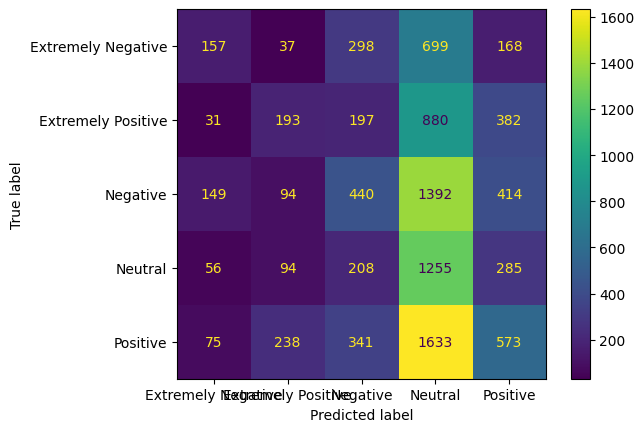

In [71]:
ConfusionMatrixDisplay.from_predictions(df.Sentiment, df.Predict_Sentiment)
plt.show()

Судя по главной диагонали, всё, конечно, весьма и весьма плоховато. Самый "плохо предсказываемый" класс это Neutral. Попробую посчитать метрику в цифрах.

In [73]:
accuracy_score(df.Sentiment, df.Predict_Sentiment)

0.25444649625813975

## Краткий вывод:

В ходе проведенных исследований были испробованы две гипотезы. Первая о том, что для классификации может быть использована информация о длине сообщения, а вторая, что могут быть использованы какие-то уникальные слова, которые присутствуют только в "положительных" и только в "отрицательных" сообщениях. Эти гипотезы сработали не очень-то хорошо. Дополнительно на это повлияло то, что в метки классов были введены градации "очень_положительные" и "очень_отрицательные". Для самой простой эвристики нужно было оставить только три класса. Но переделывать уже не буду, как есть так есть. Попробую сделать последний заход с измерением частоты встречаемости слов в текстах разных классов.

## Последний заход - пробуем использовать wordcloud (и да, это всё ещё не ML)

In [158]:
df_text = df.Text.to_list()
df_text = ' '.join(df_text).lower()
wordcloud = WordCloud()
wordcloud.process_text(df_text)

{'paper': 15,
 'anyone': 384,
 'fear': 273,
 'co': 61,
 'kvalqqvhl2': 1,
 'emericanjohnson': 1,
 'work': 1318,
 'major': 175,
 'store': 431,
 'want': 595,
 'self': 81,
 'quarantine': 428,
 'paid': 130,
 'dip': 23,
 'earned': 5,
 'vacation': 12,
 'time': 1722,
 'way': 705,
 'leave': 196,
 'diagnosed': 24,
 'covid': 4894,
 'lady': 65,
 'tramp': 2,
 'remake': 2,
 'facebook': 63,
 'instagram': 12,
 'twitter': 56,
 'toiletpaper': 454,
 'toiletpapercrisis': 20,
 'toiletpaperchallenge': 13,
 'stockingup': 4,
 'covid19': 633,
 'qhu4axa8vz': 1,
 'caremongering': 3,
 'maskfear': 1,
 'unlike': 19,
 'indulged': 1,
 'panic': 308,
 'food': 2307,
 'buying': 268,
 'throng': 2,
 'marijuana': 10,
 'bring': 185,
 'stress': 76,
 'favourite': 19,
 'supermarket': 3491,
 'today': 883,
 'saw': 186,
 'local': 439,
 'customer': 753,
 'later': 86,
 'happened': 66,
 'struggling': 157,
 'amp': 3515,
 'drink': 61,
 'cleaning': 78,
 'supplies': 369,
 'health': 400,
 'beauty': 40,
 's': 1516,
 'meat': 185,
 'new': 13

Идея в том, что я попробую учесть частоту встречаемости слова в позитивных и негативных комментариях. То есть если в позитивных комментариях слово встречается 100 раз, а в негативных всего 1 раз, значит это "позитивное" слово и, соответственно, это свидетельствует о том, что сообщение, его содержащее, скорее всего позитивное. Для простоты (мы же тут совсем простые эвристики используем), количество классов я сокращу до 3 - нейтральное, позитивное, негативное. Чтобы оценить подход в целом.

In [160]:
neutral = df[df.Sentiment == 'Neutral']
positive = df[
    (df.Sentiment == 'Positive') |
    (df.Sentiment == 'Extremely Positive')]
negative = df[
    (df.Sentiment == 'Negative') |
    (df.Sentiment == 'Extremely Negative')]
print('neutral', neutral.shape)
print('positive', positive.shape)
print('negative', negative.shape)

neutral (5813, 2)
positive (13503, 2)
negative (11550, 2)


Классы "позитив" - "негатив" более-менее сбалансированы, но "нейтральные" прямо сильно меньше. Я думаю, что наибольшую ошибку из-за этого и по некоторым другим причинам мы получим именно для "нейтральных" сообщений. Но в моей концепции с "нейтральными" сообщениями я и не буду ничего делать, обработке подвергнутся только множества "положительных" и "отрицательных" слов.

In [165]:
negative_text = negative.Text.to_list()
negative_text = preprocess(negative_text)
negative_text = ' '.join(negative_text)
negative_text = wordcloud.process_text(negative_text)
negative_text

{'fear': 207,
 'httpstcokvalqqvhl': 1,
 'caremongering': 1,
 'maskfear': 1,
 'covid': 2290,
 'unlike': 6,
 'indulged': 1,
 'panic': 119,
 'food': 956,
 'buying': 89,
 'throng': 1,
 'marijuana': 2,
 'bring': 66,
 'stress': 51,
 'favourite': 10,
 'supermarket': 1265,
 'today': 300,
 'saw': 74,
 'local': 162,
 'customer': 257,
 'later': 41,
 'happened': 34,
 'struggling': 85,
 'amp': 1337,
 'drink': 16,
 'cleaning': 27,
 'supplies': 138,
 'toilet': 3,
 'paper': 19,
 'health': 79,
 'beauty': 3,
 'meat': 97,
 'consumer': 568,
 'economy': 224,
 'world': 240,
 'dependent': 4,
 'spending': 54,
 'good': 236,
 'gt': 24,
 'cut': 141,
 'back': 172,
 'grapple': 7,
 'w': 87,
 'uncertainties': 3,
 'regarding': 21,
 'bankrate': 1,
 'survey': 42,
 'pledge': 1,
 'hoard': 43,
 'essential': 136,
 'tame': 1,
 'palate': 1,
 'stock': 346,
 'last': 94,
 'longer': 54,
 'immediate': 15,
 'basis': 12,
 'finminindia': 4,
 'announce': 17,
 'fin': 2,
 'task': 11,
 'force': 31,
 'keep': 246,
 'bay': 9,
 'blanket': 1

In [166]:
positive_text = positive.Text.to_list()
positive_text = preprocess(positive_text)
positive_text = ' '.join(positive_text)
positive_text = wordcloud.process_text(positive_text)
positive_text

{'repeat': 9,
 'call': 167,
 'respect': 68,
 'consumerprotection': 4,
 'support': 381,
 'travel': 108,
 'tourism': 11,
 'business': 277,
 'package': 66,
 'eu_commission': 3,
 'httpstcoeawbmgflm': 1,
 'httpstcopoidjlb': 1,
 'karyndarley': 1,
 'khutso': 1,
 'africafactszone': 1,
 'hold': 38,
 'breath': 8,
 'corruption': 5,
 'old': 45,
 'adam': 3,
 'eve': 2,
 'everywhere': 34,
 'imagine': 33,
 'even': 314,
 'america': 72,
 'inflicted': 1,
 'sanitizer': 255,
 'era': 9,
 'covid': 2761,
 'important': 202,
 'safe': 229,
 'online': 442,
 'shopping': 370,
 'post': 98,
 'malwarebytes': 3,
 'httpstcovsvdpz': 1,
 'awkward': 2,
 'moment': 61,
 'realize': 18,
 'supermarket': 1352,
 'better': 242,
 'protection': 31,
 'stop': 115,
 'without': 179,
 'protecting': 35,
 'health': 226,
 'first': 172,
 'said': 223,
 'director': 12,
 'general': 26,
 'dr': 41,
 'ta': 5,
 'ghebreyesus': 1,
 'due': 164,
 'n': 74,
 'amp': 1844,
 'going': 420,
 'multifold': 2,
 'best': 254,
 'wayout': 1,
 'british': 29,
 'love':

In [168]:
print(positive_text['fuck'])
print(negative_text['fuck'])

18
108


Чуть выше я слегка проиллюстрировал свою идею. Так как слово 'fuck' встречается в "негативных" комментариях значительно чаще, чем в "позитивных", оно имеет явно негативную коннотацию. Чтобы выразить это численно, можно просто учесть частоту встречаемости слова в негативных комментариях как отрицательное число (-108), а в положительных - как положительное (18). Тогда их сумма будет равна -90. Соответственно, целевой класс этого слова определяем по знаку как негативный. Целевой класс всего сообщения определим, суммировав полученные таким образом значения слов во всем сообщении.

In [170]:
# Снова загружаем  тестовый датасет
df_test = pd.read_csv('val_data.csv', index_col=0)
df_test.head(5)

,Text,Sentiment
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative
23458,I would place a large amount of money this is ...,Neutral
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive


In [190]:
# Немного изменю свой разметчик
def labeling_str(row: str) -> int:
    '''
    Присваиваем сообщению числовую метку в зависимости
    от частоты встречаемости слова в списках "плохих" и
    "хороших" слов.
    '''
    global positive_text
    global negative_text   
    row = row.split()
    row = preprocess(row)
    cnt = 0
    for word in row:
        if word in positive_text.keys():
            cnt = positive_text[word]
        elif word in negative_text.keys():
            cnt = -1 * negative_text[word] 
        else:
            cnt = 0
        cnt += cnt      # "Суммируем" все слова в предложении

    label = ''
    if cnt == 0 & (len(row) <= 61):
        label = 'Neutral'
    elif cnt > 1:
        label = 'Positive'
    elif cnt < -1:
        label = 'Negative'

    return label

In [191]:
dff = df_test.copy()
dff['Predict_Sentiment'] = dff['Text'].apply(labeling_str)
dff.head(10)

,Text,Sentiment,Predict_Sentiment
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative,Positive
23458,I would place a large amount of money this is ...,Neutral,Negative
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral,Neutral
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive,Neutral
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive,Positive
20962,Whenever you touch any object or surface outsi...,Neutral,Neutral
9331,P.S.A for those buying ?. The human body can s...,Extremely Positive,Positive
25031,Publix. Walmart. Thats how its spreading throu...,Neutral,Negative
26361,Our healthcare community is the backbone of th...,Extremely Positive,Neutral
26675,Lilliesleaf clapped as Alan played for NHS wo...,Positive,Neutral


In [192]:
# Для простоты изменим количество классов в выборке
dff.Sentiment[dff.Sentiment == 'Extremely Negative'] = 'Negative'
dff.Sentiment[dff.Sentiment == 'Extremely Positive'] = 'Positive'

In [193]:
dff.head(10)

,Text,Sentiment,Predict_Sentiment
14623,So panic buying of soaps and toilet roll was b...,Negative,Positive
23458,I would place a large amount of money this is ...,Neutral,Negative
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral,Neutral
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Positive,Neutral
22272,I d like to know who is stockpiling eggs chees...,Positive,Positive
20962,Whenever you touch any object or surface outsi...,Neutral,Neutral
9331,P.S.A for those buying ?. The human body can s...,Positive,Positive
25031,Publix. Walmart. Thats how its spreading throu...,Neutral,Negative
26361,Our healthcare community is the backbone of th...,Positive,Neutral
26675,Lilliesleaf clapped as Alan played for NHS wo...,Positive,Neutral


## Смотрим метрику

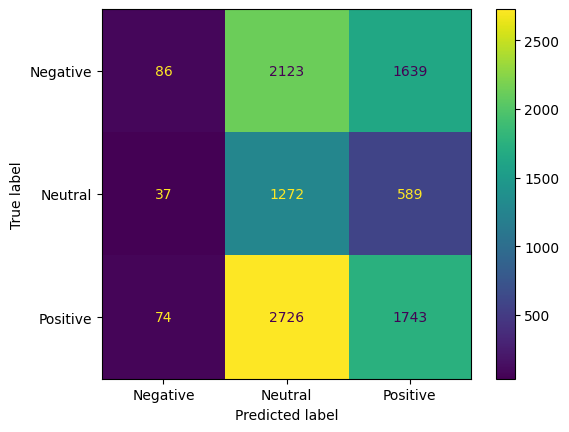

In [194]:
ConfusionMatrixDisplay.from_predictions(dff.Sentiment, dff.Predict_Sentiment)
plt.show()

По-моему стало ещё хуже :)

In [195]:
accuracy_score(dff.Sentiment, dff.Predict_Sentiment)

0.3013898338030907

Итоговая метрика чуть подросла, но это только за счёт уменьшения количества классов. В реальности (и это странно) точность вот такого вот подхода КМК уменьшилась.

## Вывод

Какими-то простыми способами классифицировать текст, очевидно, не удалось. Нужно подключать методы машинного обучения и векторизации текстов. Чем я и займусь во второй часть работы.

# Часть вторая - вседозволенность (используем алгоритмы ML)

Для разогрева я попробую применить тот же подход с анализом частоты встречаемости слов в "позитивных" и "негативных" сообщениях, но анализ делать не простым суммированием, а с помощью моделей машинного обучения для табличных данных. Для этого я каждое сообщение буду переводить в числовой вид, присваивая каждому слову в сообщению числовое значение (количество вхождений во множество "позитивных" сообщений - количество вхождений во множество "негативных" сообщений.) 

In [196]:
# Загружаем датасет, смотрим структуру данных
df = pd.read_csv('train_data.csv', index_col=0)
df.head(5)

,Text,Sentiment
15124,Toilet paper anyone,Neutral
33827,This is my fear: https://t.co/kvAlqqvhl2,Negative
5652,"@EmericanJohnson I work at ""the"" major grocery...",Neutral
20216,"""Lady and the Tramp"" remake. ?\r\r\n.\r\r\n. \...",Neutral
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative


Немного видоизменю свою функцию препроцессинга

In [28]:
def preprocess(row: str) -> str:
    '''Функция принимает на вход список сообщений, предобрабатывает его,
       и возвращет без лишних слов :)'''
    # Приводим к нижнему регистру
    row = row.lower()
    # Удаляем ссылки
    url = re.compile(r'((?<=[^a-zA-Z0-9])(?:http|https|ftp?\:\/\/)(?:\/[a-zA-Z0-9]{1,})*)')
    row = re.sub(url, '', row)
    # Убираем цифры
    numbers = re.compile(r'\d+')
    row = re.sub(numbers, '', row)
    # Убираем пунктуацию
    punct = re.compile(r'[^\w\s]')
    row = re.sub(punct, '', row)
    # Убираем спецсимволы:
    symbols = re.compile(r'\n')
    row = re.sub(symbols, '', row)
    # Убираем лишние пробелы
    extra_spaces = re.compile(r'\s{2,}')
    row = re.sub(extra_spaces, ' ', row)
    # Лемматизация и очистка от стопслов
    morph = pymorphy2.MorphAnalyzer()
    stop = stopwords.words('english')
    row = [morph.normal_forms(word)[0] for word in row.split() if word not in stop]
    row = ' '.join(row)

    return row

In [29]:
row = preprocess('@EmericanJohnson I work at "the" major grocery')
row

'emericanjohnson work major grocery'

In [261]:
df['Cleared_text'] = df.Text.apply(preprocess)

In [263]:
df.sample(5)

,Text,Sentiment,Cleared_text
25791,@henrymcmaster I work in a definitely nonessen...,Extremely Positive,henrymcmaster work definitely nonessential ret...
27786,@GovLarryHogan @AACOPD continued.. This video ...,Positive,govlarryhogan aacopd continued video taken goi...
35031,OK so maybe the consumer journey has taken a s...,Positive,ok maybe consumer journey taken slight detour ...
35487,"My friend works in a supermarket, this was her...",Positive,friend works supermarket reply people keeping ...
1428,Nearly 40 percent of states have announced sta...,Neutral,nearly percent states announced statewide clos...


In [264]:
df.to_csv('train_data_cleared.csv', index=True)

## Способ первый - пробую классические методы ML с использованием самодельного частотного подхода к числовому представлению слов

In [2]:
df = pd.read_csv('train_data_cleared.csv', index_col=0)
df.head(5)

,Text,Sentiment,Cleared_text
15124,Toilet paper anyone,Neutral,toilet paper anyone
33827,This is my fear: https://t.co/kvAlqqvhl2,Negative,fear stcokvalqqvhl
5652,"@EmericanJohnson I work at ""the"" major grocery...",Neutral,emericanjohnson work major grocery store want ...
20216,"""Lady and the Tramp"" remake. ?\r\r\n.\r\r\n. \...",Neutral,lady tramp remake facebook stcoqevbiznbr insta...
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative,caremongering maskfear coronavirus covid unlik...


In [3]:
neutral = df[df.Sentiment == 'Neutral']
positive = df[
    (df.Sentiment == 'Positive') |
    (df.Sentiment == 'Extremely Positive')]
negative = df[
    (df.Sentiment == 'Negative') |
    (df.Sentiment == 'Extremely Negative')]
print('neutral', neutral.shape)
print('positive', positive.shape)
print('negative', negative.shape)

neutral (5813, 3)
positive (13503, 3)
negative (11550, 3)


In [5]:
wordcloud = WordCloud()

In [6]:
negative_text = negative.Cleared_text.to_list()
negative_text = ' '.join(negative_text)
negative_text = wordcloud.process_text(negative_text)

In [7]:
positive_text = positive.Cleared_text.to_list()
positive_text = ' '.join(positive_text)
positive_text = wordcloud.process_text(positive_text)

In [16]:
# Немного изменю свой разметчик
# Я понял, в чём я накосячил в прошлый раз
# и почему мой подход так криво сработал в
# предыдущей части, сейчас я исправлю ошибку

def str_to_num(row: str) -> list:
    '''
    Переводим слова в числа с использованием
    частотного подхода
    '''
    global positive_text
    global negative_text
    try:
        row = row.split()
    except:
        row = []
    for idx, word in enumerate(row):
        positive_cnt = 0
        negative_cnt = 0
        if word in positive_text.keys():
            positive_cnt = positive_text[word]
        if word in negative_text.keys():
            negative_cnt = negative_text[word] 
        row[idx] = positive_cnt - negative_cnt

    return row

In [9]:
# Минутка тестирования алгоритма
row = str_to_num('fear fuck terrible love hope shop')
row

[-186, -90, -8, 170, 171, 76]

In [12]:
dff = df.copy()

In [17]:
dff['Nums_text'] = dff['Cleared_text'].apply(str_to_num)
dff.head(5)

,Text,Sentiment,Cleared_text,Nums_text
15124,Toilet paper anyone,Neutral,toilet paper anyone,"[-3, -19, 31]"
33827,This is my fear: https://t.co/kvAlqqvhl2,Negative,fear stcokvalqqvhl,"[-186, -1]"
5652,"@EmericanJohnson I work at ""the"" major grocery...",Neutral,emericanjohnson work major grocery store want ...,"[0, 130, -8, 0, -221, 105, -7, 21, 0, 7, -1, -..."
20216,"""Lady and the Tramp"" remake. ?\r\r\n.\r\r\n. \...",Neutral,lady tramp remake facebook stcoqevbiznbr insta...,"[6, 0, 1, 16, 0, 8, 0, 1, 0, 84, -3, 8, -3, 0,..."
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative,caremongering maskfear coronavirus covid unlik...,"[0, -1, 0, 471, 3, 0, -1, -22, -132, 33, 0, -1..."


Ну вот, всё как доктор прописал

In [18]:
numerized_text = dff['Nums_text'].to_list()

In [19]:
numerized_text = pd.DataFrame(numerized_text)

In [21]:
numerized_text.shape

(30866, 41)

In [20]:
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-3.0,-19.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-186.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,130.0,-8.0,0.0,-221.0,105.0,-7.0,21.0,0.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.0,0.0,1.0,16.0,0.0,8.0,0.0,1.0,0.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-1.0,0.0,471.0,3.0,0.0,-1.0,-22.0,-132.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В принципе, получилась готовый датасет со словами, преобразованными в их числовое представление на основе частотного подхода. Пустышки заполню нулями.

In [22]:
numerized_text.fillna(0, inplace=True)
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-3.0,-19.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-186.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,130.0,-8.0,0.0,-221.0,105.0,-7.0,21.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,0.0,1.0,16.0,0.0,8.0,0.0,1.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.0,0.0,471.0,3.0,0.0,-1.0,-22.0,-132.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавляю столбец с целевой переменной

In [23]:
numerized_text['Sentiment'] = dff['Sentiment'].reset_index(drop=True)

In [24]:
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Sentiment
0,-3.0,-19.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
1,-186.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,0.0,130.0,-8.0,0.0,-221.0,105.0,-7.0,21.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,6.0,0.0,1.0,16.0,0.0,8.0,0.0,1.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
4,0.0,-1.0,0.0,471.0,3.0,0.0,-1.0,-22.0,-132.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Negative


## Catboost

In [25]:
X = numerized_text.drop('Sentiment', axis=1)
y = numerized_text['Sentiment']
features_names = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
train_data = Pool(
    data=X_train, 
    label=y_train,
    cat_features=[],
    feature_names=features_names
)
eval_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=[],
    feature_names=features_names
)
model = CatBoostClassifier(iterations=5000, early_stopping_rounds=100)
model.fit(X=train_data, eval_set=eval_data)

Learning rate set to 0.062255
0:	learn: 1.5904063	test: 1.5906970	best: 1.5906970 (0)	total: 207ms	remaining: 17m 16s
1:	learn: 1.5727611	test: 1.5740504	best: 1.5740504 (1)	total: 245ms	remaining: 10m 12s
2:	learn: 1.5558648	test: 1.5584917	best: 1.5584917 (2)	total: 280ms	remaining: 7m 46s
3:	learn: 1.5390502	test: 1.5425102	best: 1.5425102 (3)	total: 325ms	remaining: 6m 45s
4:	learn: 1.5233979	test: 1.5274307	best: 1.5274307 (4)	total: 367ms	remaining: 6m 6s
5:	learn: 1.5090709	test: 1.5140015	best: 1.5140015 (5)	total: 410ms	remaining: 5m 41s
6:	learn: 1.4951994	test: 1.5013078	best: 1.5013078 (6)	total: 453ms	remaining: 5m 23s
7:	learn: 1.4832669	test: 1.4901534	best: 1.4901534 (7)	total: 506ms	remaining: 5m 15s
8:	learn: 1.4720850	test: 1.4793602	best: 1.4793602 (8)	total: 550ms	remaining: 5m 5s
9:	learn: 1.4616583	test: 1.4693991	best: 1.4693991 (9)	total: 588ms	remaining: 4m 53s
10:	learn: 1.4517169	test: 1.4609075	best: 1.4609075 (10)	total: 625ms	remaining: 4m 43s
11:	learn: 

Ошибка довольно большая, это печально. Попробую посмотреть метрику на валидационной выборке.

In [27]:
# Загружаем датасет, смотрим структуру данных
df_val = pd.read_csv('val_data.csv', index_col=0)
df_val.head(5)

,Text,Sentiment
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative
23458,I would place a large amount of money this is ...,Neutral
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive


In [30]:
df_val['Cleared_text'] = df_val.Text.apply(preprocess)
df_val.head(5)

,Text,Sentiment,Cleared_text
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative,panic buying soaps toilet roll bad enough idio...
23458,I would place a large amount of money this is ...,Neutral,would place large amount money guy buying toil...
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral,saudi arabia bracing economic downturn oil pri...
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive,foodsecurity coronavirus covid smooth flow glo...
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive,like know stockpiling eggs cheese ice cream us...


In [31]:
df_val.to_csv('val_data_cleared.csv', index=True)

In [32]:
dff = df_val.copy()

In [33]:
dff['Nums_text'] = dff['Cleared_text'].apply(str_to_num)
dff.head(5)

,Text,Sentiment,Cleared_text,Nums_text
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative,panic buying soaps toilet roll bad enough idio...,"[-22, 33, 0, -3, 5, -88, -59, 0, -35, 20, -10,..."
23458,I would place a large amount of money this is ...,Neutral,would place large amount money guy buying toil...,"[0, 28, 29, -2, -71, 25, 33, -3, -19]"
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral,saudi arabia bracing economic downturn oil pri...,"[5, 0, -7, -13, -3, 31, 0, -7, -99, 0, 81, 0]"
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive,foodsecurity coronavirus covid smooth flow glo...,"[-12, 0, 471, 3, 5, -35, 8, 603, 18, -132, -12..."
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive,like know stockpiling eggs cheese ice cream us...,"[0, 87, -35, 0, -2, 1, 3, 7, 30, 43, 68, 2, 22..."


In [34]:
numerized_text = dff['Nums_text'].to_list()
numerized_text = pd.DataFrame(numerized_text)
numerized_text.fillna(0, inplace=True)
numerized_text['Sentiment'] = dff['Sentiment'].reset_index(drop=True)
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Sentiment
0,-22,33.0,0.0,-3.0,5.0,-88.0,-59.0,0.0,-35.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Negative
1,0,28.0,29.0,-2.0,-71.0,25.0,33.0,-3.0,-19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
2,5,0.0,-7.0,-13.0,-3.0,31.0,0.0,-7.0,-99.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,-12,0.0,471.0,3.0,5.0,-35.0,8.0,603.0,18.0,-132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Positive
4,0,87.0,-35.0,0.0,-2.0,1.0,3.0,7.0,30.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Positive


In [35]:
numerized_text.shape

(10289, 41)

Не хватает одного столбца, добавлю его

In [36]:
numerized_text['40'] = 0

In [39]:
X = numerized_text.drop('Sentiment', axis=1)
numerized_text['Predicted_label'] = model.predict(X)

## Смотрим метрику

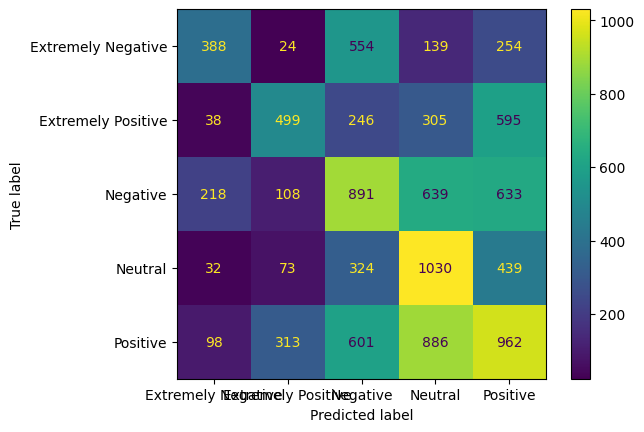

In [40]:
ConfusionMatrixDisplay.from_predictions(numerized_text.Sentiment, numerized_text.Predicted_label)
plt.show()

Нуу, уже гораздо лучше, судя по таблице. Смотрим accuracy

In [41]:
accuracy_score(numerized_text.Sentiment, numerized_text.Predicted_label)

0.36641072990572454

Метрика прямо печальная, конечно. Пробую немного другой подход, превратив это в задачу регрессии.

## Подход №2 (с извращениями)

In [48]:
# Загружаю очищенные тренировочные данные для обучения модели
df_train = pd.read_csv('train_data_cleared.csv', index_col=0)
df_train.head(5)

,Text,Sentiment,Cleared_text
15124,Toilet paper anyone,Neutral,toilet paper anyone
33827,This is my fear: https://t.co/kvAlqqvhl2,Negative,fear stcokvalqqvhl
5652,"@EmericanJohnson I work at ""the"" major grocery...",Neutral,emericanjohnson work major grocery store want ...
20216,"""Lady and the Tramp"" remake. ?\r\r\n.\r\r\n. \...",Neutral,lady tramp remake facebook stcoqevbiznbr insta...
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative,caremongering maskfear coronavirus covid unlik...


In [49]:
df_train['Nums_text'] = df_train['Cleared_text'].apply(str_to_num)
numerized_text = df_train['Nums_text'].to_list()
numerized_text = pd.DataFrame(numerized_text)
numerized_text.fillna(0, inplace=True)
numerized_text['Sentiment'] = df_train['Sentiment'].reset_index(drop=True)
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Sentiment
0,-3.0,-19.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
1,-186.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,0.0,130.0,-8.0,0.0,-221.0,105.0,-7.0,21.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,6.0,0.0,1.0,16.0,0.0,8.0,0.0,1.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
4,0.0,-1.0,0.0,471.0,3.0,0.0,-1.0,-22.0,-132.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Negative


In [50]:
grade = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
}
numerized_text['Sentiment'] = numerized_text['Sentiment'].astype('category').cat.rename_categories(grade)

In [51]:
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Sentiment
0,-3.0,-19.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-186.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,130.0,-8.0,0.0,-221.0,105.0,-7.0,21.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,6.0,0.0,1.0,16.0,0.0,8.0,0.0,1.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,-1.0,0.0,471.0,3.0,0.0,-1.0,-22.0,-132.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2


In [52]:
X = numerized_text.drop('Sentiment', axis=1)
y = numerized_text['Sentiment']
features_names = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
train_data = Pool(
    data=X_train, 
    label=y_train,
    cat_features=[],
    feature_names=features_names
)
eval_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=[],
    feature_names=features_names
)
model = CatBoostRegressor(iterations=5000, early_stopping_rounds=100)
model.fit(X=train_data, eval_set=eval_data)

Learning rate set to 0.031561
0:	learn: 1.2877370	test: 1.2990446	best: 1.2990446 (0)	total: 16.8ms	remaining: 1m 24s
1:	learn: 1.2802151	test: 1.2916615	best: 1.2916615 (1)	total: 27.3ms	remaining: 1m 8s
2:	learn: 1.2728402	test: 1.2844576	best: 1.2844576 (2)	total: 36.3ms	remaining: 1m
3:	learn: 1.2655076	test: 1.2772774	best: 1.2772774 (3)	total: 49.1ms	remaining: 1m 1s
4:	learn: 1.2585844	test: 1.2701685	best: 1.2701685 (4)	total: 58.8ms	remaining: 58.7s
5:	learn: 1.2518129	test: 1.2635691	best: 1.2635691 (5)	total: 67.1ms	remaining: 55.8s
6:	learn: 1.2453973	test: 1.2572513	best: 1.2572513 (6)	total: 75.8ms	remaining: 54.1s
7:	learn: 1.2391210	test: 1.2508353	best: 1.2508353 (7)	total: 87ms	remaining: 54.3s
8:	learn: 1.2329973	test: 1.2448469	best: 1.2448469 (8)	total: 96ms	remaining: 53.2s
9:	learn: 1.2267299	test: 1.2388975	best: 1.2388975 (9)	total: 107ms	remaining: 53.4s
10:	learn: 1.2207769	test: 1.2329288	best: 1.2329288 (10)	total: 116ms	remaining: 52.6s
11:	learn: 1.215074

In [56]:
df_vav = pd.read_csv('val_data_cleared.csv', index_col=0)
df_val.head(5)

,Text,Sentiment,Cleared_text,Nums_text
14623,So panic buying of soaps and toilet roll was b...,Extremely Negative,panic buying soaps toilet roll bad enough idio...,"[-22, 33, 0, -3, 5, -88, -59, 0, -35, 20, -10,..."
23458,I would place a large amount of money this is ...,Neutral,would place large amount money guy buying toil...,"[0, 28, 29, -2, -71, 25, 33, -3, -19]"
8170,"""Saudi Arabia is bracing for an economic downt...",Neutral,saudi arabia bracing economic downturn oil pri...,"[5, 0, -7, -13, -3, 31, 0, -7, -99, 0, 81, 0]"
31036,#Foodsecurity #coronavirus #covid19 \r\r\n1.Sm...,Extremely Positive,foodsecurity coronavirus covid smooth flow glo...,"[-12, 0, 471, 3, 5, -35, 8, 603, 18, -132, -12..."
22272,I d like to know who is stockpiling eggs chees...,Extremely Positive,like know stockpiling eggs cheese ice cream us...,"[0, 87, -35, 0, -2, 1, 3, 7, 30, 43, 68, 2, 22..."


In [58]:
#df_val['Nums_text'] = df_val['Cleared_text'].apply(str_to_num)
numerized_text = df_val['Nums_text'].to_list()
numerized_text = pd.DataFrame(numerized_text)
numerized_text.fillna(0, inplace=True)
numerized_text['Sentiment'] = df_val['Sentiment'].reset_index(drop=True)
numerized_text['40'] = 0
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,Sentiment,40
0,-22,33.0,0.0,-3.0,5.0,-88.0,-59.0,0.0,-35.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Negative,0
1,0,28.0,29.0,-2.0,-71.0,25.0,33.0,-3.0,-19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,0
2,5,0.0,-7.0,-13.0,-3.0,31.0,0.0,-7.0,-99.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral,0
3,-12,0.0,471.0,3.0,5.0,-35.0,8.0,603.0,18.0,-132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Positive,0
4,0,87.0,-35.0,0.0,-2.0,1.0,3.0,7.0,30.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Positive,0


In [59]:
grade = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
}
numerized_text['Sentiment'] = numerized_text['Sentiment'].astype('category').cat.rename_categories(grade)

In [60]:
X = numerized_text.drop('Sentiment', axis=1)
numerized_text['Predicted_label'] = model.predict(X)

In [61]:
numerized_text.head(5)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,Sentiment,40,Predicted_label
0,-22,33.0,0.0,-3.0,5.0,-88.0,-59.0,0.0,-35.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2,0,-0.657009
1,0,28.0,29.0,-2.0,-71.0,25.0,33.0,-3.0,-19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.386774
2,5,0.0,-7.0,-13.0,-3.0,31.0,0.0,-7.0,-99.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.546556
3,-12,0.0,471.0,3.0,5.0,-35.0,8.0,603.0,18.0,-132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,-0.513495
4,0,87.0,-35.0,0.0,-2.0,1.0,3.0,7.0,30.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1.078362


In [63]:
def round_label(label: float) -> int:
    '''Округляю получившиеся значения'''
    return round(label)

In [65]:
numerized_text['Predicted_label'] = numerized_text['Predicted_label'].apply(round_label)

In [ ]:
numerized_text['Predicted_label'][numerized_text['Predicted_label'] > 2] = 2
numerized_text['Predicted_label'][numerized_text['Predicted_label'] < -2] = -2

## Смотрю метрику

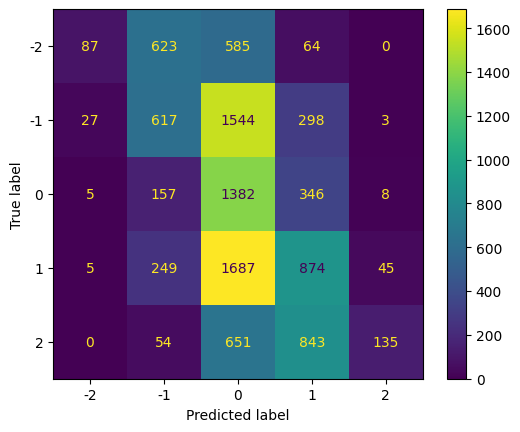

In [71]:
ConfusionMatrixDisplay.from_predictions(numerized_text.Sentiment, numerized_text.Predicted_label)
plt.show()

In [72]:
accuracy_score(numerized_text.Sentiment, numerized_text.Predicted_label)

0.30080668675284283

Что мы здесь видим: для классов "очень негативное" и "очень позитивное" модель показала себя хорошо. С приближением к "нейтральному" она начинает ошибаться всё больше и самые большие ошибки допускает в классе "нейтральное". К безусловным плюсам модели можно отнести то, что ошибок между "далекими" классами (например, позитивное-негативное), довольно немного. В основном ошибки касаются "близких" классов (например, просто "негативное" классифицируется как "очень негативное").

## Заканчиваю баловство, применяю нормальную векторизацию

In [4]:
# Загружаю очищенные тренировочные данные для обучения модели
df_train = pd.read_csv('train_data_cleared.csv', index_col=0)
df_train.head(5)

,Text,Sentiment,Cleared_text
15124,Toilet paper anyone,Neutral,toilet paper anyone
33827,This is my fear: https://t.co/kvAlqqvhl2,Negative,fear stcokvalqqvhl
5652,"@EmericanJohnson I work at ""the"" major grocery...",Neutral,emericanjohnson work major grocery store want ...
20216,"""Lady and the Tramp"" remake. ?\r\r\n.\r\r\n. \...",Neutral,lady tramp remake facebook stcoqevbiznbr insta...
10852,#Caremongering #maskFear #CoronaVirus #Covid-1...,Extremely Negative,caremongering maskfear coronavirus covid unlik...


In [5]:
df_train.dropna(inplace=True)
X = df_train.Cleared_text
y = df_train.Sentiment

In [105]:
# Применяю TFiDF векторизацию от SKLearn
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vect,
    y,
    test_size=0.25,
    random_state = 42
)

In [107]:
# Пробую использовать наивную байесовскую классификацию
model = MultinomialNB()
model.fit(X_train, y)

y_pred = model.predict(X_test)

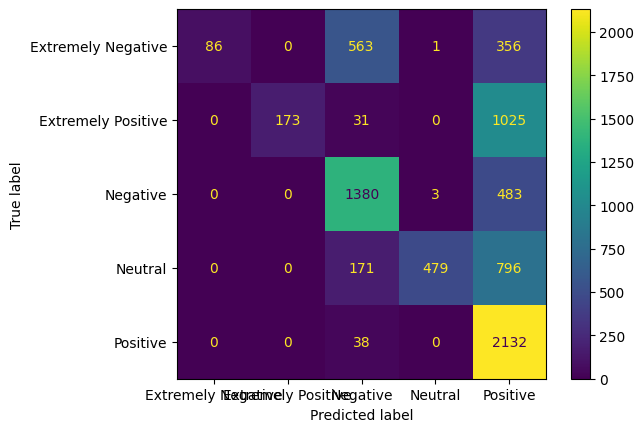

In [108]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [109]:
accuracy_score(y_test, y_pred)

0.5507321497991448

Чтож, остается признать безоговорочного преимущества промышленной векторизации перед моими методами. 0.55, конечно, так себе метрика, но судя по confusion matrix все более-менее. Если уменьшить количество классов, будет вполне себе неплохая.

## Catboost

Попробую другой алгоритм машинного обучения и другой способ векторизации текста.

In [6]:
# Создаем экземпляр векторизатора
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vect,
    y,
    test_size=0.25,
    random_state = 42
)

In [8]:
train_data = Pool(
    data=X_train, 
    label=y_train,
    cat_features=[])
eval_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=[])
model = CatBoostClassifier(iterations=500, early_stopping_rounds=100)
model.fit(X=train_data, eval_set=eval_data)

Learning rate set to 0.149834
0:	learn: 1.5771908	test: 1.5771406	best: 1.5771406 (0)	total: 654ms	remaining: 5m 26s
1:	learn: 1.5568400	test: 1.5562686	best: 1.5562686 (1)	total: 1.19s	remaining: 4m 56s
2:	learn: 1.5387635	test: 1.5384744	best: 1.5384744 (2)	total: 1.78s	remaining: 4m 55s
3:	learn: 1.5246469	test: 1.5250909	best: 1.5250909 (3)	total: 2.21s	remaining: 4m 33s
4:	learn: 1.5086427	test: 1.5086680	best: 1.5086680 (4)	total: 2.64s	remaining: 4m 21s
5:	learn: 1.4937567	test: 1.4930736	best: 1.4930736 (5)	total: 3.08s	remaining: 4m 13s
6:	learn: 1.4825092	test: 1.4818989	best: 1.4818989 (6)	total: 3.49s	remaining: 4m 5s
7:	learn: 1.4727355	test: 1.4721130	best: 1.4721130 (7)	total: 3.9s	remaining: 3m 59s
8:	learn: 1.4652445	test: 1.4645448	best: 1.4645448 (8)	total: 4.32s	remaining: 3m 55s
9:	learn: 1.4569628	test: 1.4566095	best: 1.4566095 (9)	total: 4.72s	remaining: 3m 51s
10:	learn: 1.4487769	test: 1.4483123	best: 1.4483123 (10)	total: 5.13s	remaining: 3m 48s
11:	learn: 1.

В принципе, обучение можно ещё продолжать и продолжать, до переобучения ещё очень далеко. Но для примерной оценки качества модели этого будет достаточно.

In [9]:
y_pred = model.predict(X_test)

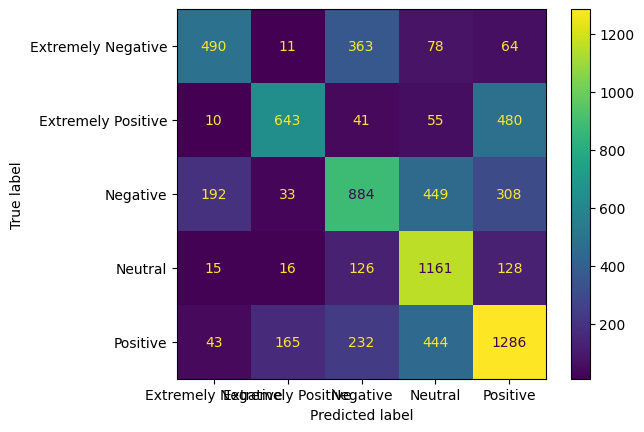

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [11]:
# Смотрим весь набор метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(accuracy)
print(precision)
print(recall)
print(f1)

0.5784631333419723
0.5920664722042519
0.5784631333419723
0.5749477172429271


Немного улучшили метрику по сравнению с предыдущей моделью.

# Общий вывод:

Мною была проделана следующая работа:
- Произведен общий осмотр и анализ представленного датасета, в ходе которого установлено, что датасет состоит из тестовых сообщений с метками 5-ти типов (от "крайне негативное" до "крайне позитивное"). Сообщения посвящены теме Covid-19 (видимо, из чатов или форумов). Классы в датасете разделены на более-менее равные группы, поэтому балансировку классов я делать не стал. (но если бы требовалось мог бы :))
- Поверхностно затронута тема эвристик на основе статистических данных текста. Я обнаружил, что "позитивные" сообщения как правило длинее "негативных". Других наивных эвристик на основе статистик текста, символов (хештегов и прочего) я не нашел, так как не особенно искал. Думаю, что на подобные различия не стоит опираться (вывод из жизненного опыта).
- Я попробовал использовать "наивные эвристики" на основе предположения, что в "положительных" или "отрицательных" сообщениях количество вхождений разных слов разное. Типа, слово love гораздо чаще в "позитивных", а fuck в негативных комментариях. Для определения частотности использования слов я применил методы wordcloud, составив два облака из "негативных" и "позитивных" комментариев. После этого я пробовал определять знак и числовое выражение предложения на основании суммы вхождений его слов в "положительные" и "отрицательные" облака (с соответствующим знаком) - в разделе "простых" эвристик", а также попробовал создать числовые представления сообщений из числовых представлений слов (по вышеуказанному методу) и использовать это в качестве табличных данных для модели Catboost. Все эти попытки закончились не вполне удачно, метрики были очень печальные.
- В итоге я применил векторизацию TFIDF и CountVectorizer "из коробки" от библиотеки SKLearn, на основании которой сделал две модели (с использованием алгоритма наивной байесовской многоклассовой классификации и Catboost). Метрики получились "не ахти", но уже значительно лучше предыдущих заходов. К следующему заданию планирую побить текущие рекорды.